# CNN Cross-validation Training Template
* The purpose of this notebook is to provide an environment for using k-fold cross-validation to train convolutional neural networks.
* It is possible to choose a specific preprocessing function that will be applied to generated images, whether traditional k-fold or stratified k-fold will be used and which model architecture will be trained.
* The cross-validation loop saves model with best validation accuracy per each fold and after training, the overall best model is evaluated on the test set.
* The template allows for training on the state-of-the-art COVIDx8B and the older COVIDx3 datasets.


*Author: Dominik Chodounský, FIT CTU in Prague (Last edit: 05/11/21)*

## Library Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
import numpy as np
import os
import sys

## Constants and Settings
* Set variable *ROOT_DIR* to contain path to root *BI-BAP* folder.
* Set variable *TRAIN_DIR* to contain the path to the training data folder (default values are meant for training on the COVIDx8B positive class data).
* Set variable *SAVE_DIR* to contain the path to *BI-BAP/models/CNN/cross-validation* folder, where trained models are saved.
* You may change the default parameters for the training as well, their description is provided in the following cell.

In [ ]:
ROOT_PATH = '../'
TRAIN_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/train')
TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/test')
SAVE_DIR = os.path.join(ROOT_PATH, 'models/CNN/training')
CHEXNET_PATH = os.path.join(ROOT_PATH, 'data/CheXNet_weights.h5')

IMG_SIZE = 224   # target width and height of images that they will be resized to
BATCH_SIZE = 16  # size of generated batches of images
CHANNEL_CNT = 3  # number of channels in images (3 = RGB, 1 = Grayscale)
EPOCH_CNT = 15   # number of epochs to use in training
SPLIT_CNT = 4    # number k of splits for k-fold cross-validation
RAND_SEED = 111  # random seed for reproducibility


# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)
random.seed(RAND_SEED)
os.environ['PYTHONHASHSEED'] = str(RAND_SEED)

warnings.filterwarnings("ignore")

---





## File Imports
* Imports files containing helper functions, model definitions, preprocessing functions, etc.

In [ ]:
from model_architectures.cnn_models import BaseNet, VGG_16, VGG_19, ResNet_50, xCeption, MobileNet_V2, COVIDNet, DenseNet_121
from utils.utils import get_crossval_generators, create_dataframe, get_class_weights, get_generators, plot_eval
from preprocessing.image_preprocessing import *
from preprocessing.covid_net_preprocessing import *

# individual preprocessing functions for pretrained models (applicable to transfer learning)
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

## Preprocessor definitions
* Preprocessing functions themselves are defined in *BI-BAP/src/preprocessing/image_preprocessing.py*, the following preprocessors are wrappers that allow for calling them within the Image Data Generators with necessary arguments.

In [ ]:
# Performs segmentation which aims to remove section of the image with high contrast (removes diaphragm)
def preprocessor_remove_diaphragm(img, img_size=(IMG_SIZE)):
    removed = remove_diaphragm(img, img_size)[-1]
    return removed / 255

# Performs RGB variant for Histogram equalization
def preprocessor_rgb_histogram_eq(img, img_size=IMG_SIZE):
    equalized = rgb_histogram_equalization(img, img_size)[-1]
    return equalized / 255

# Performs RGB variant for Contrast limited adaptive histogram equalization (CLAHE)
def preprocessor_rgb_clahe(img, img_size=IMG_SIZE):
    equalized = rgb_clahe(img, img_size)[-1]
    return equalized / 255

# Default preprocessor, only performs resize and scaling
def preprocessor(img):
    new_img = cv2.resize(img.astype('uint8'), (IMG_SIZE, IMG_SIZE))
    return new_img / 255

## Training Data sources
* Create a DataFrame containing the training data, which will be split in each fold during cross-validation.
* Create an Image Data Generator, that will be used to load data from the DataFrame for training and validation.

In [ ]:
train_df = create_dataframe(train_dir=TRAIN_DIR)
target = train_df.loc[:,'label']

In [ ]:
if CHANNEL_CNT == 1:
    datagen = ImageDataGenerator(
            preprocessing_function=preprocessor
          )
    
elif CHANNEL_CNT == 3:
    datagen = ImageDataGenerator(
            preprocessing_function=preprocessor # Choose one of the RGB preprocessors [ preprocessor, preprocessor_rgb_clage, preprocessor_rgb_histogram_eq, preprocessor_remove_diaphragm ]
                                                # or a specific preprocessing function for a transferred architecture
          )

## Cross-validation

* Objects for k-fold and stratified k-fold.

In [ ]:
kf = KFold(n_splits=SPLIT_CNT, random_state=RAND_SEED, shuffle=True)
skf = StratifiedKFold(n_splits=SPLIT_CNT, random_state=RAND_SEED, shuffle=True)

* Callback to implement Early Stopping regularization.

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    min_delta=0,
    patience=6,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

* Cross validation loop.
* You may wish to select *kf* for k-fold or *skf* for stratified k-fold.
* Loop splits data according to selected folding technique, creates data sources that supply augmented and preprocessed batches of images and a selected model is trained. The model that achieved highest validation accuracy is recorded for later use.
* Select one of the models imported from *BI-BAP/src/model_architectures/cnn_models.py*. There you can also see their initialization parameters, they all need image size and channel count as the bare minimum, some have additional optional parameters such as pre-trained weights.
* In compilation of the model, you may specify the optimizer and its parameters.


In [ ]:
valid_acc = []
valid_loss = []
histories = []

fold = 1

# cross-validation loop (pick kf for K-Fold or skf for Stratified K-Fold)
for train_index, valid_index in skf.split(X=train_df.index, y=target):

    print(f'\n---------- FOLD {fold} ----------')
    start = time.time()

    # prepare cross-validation data splits
    train_data = train_df.iloc[train_index]
    valid_data = train_df.iloc[valid_index]
    train_gen, valid_gen = get_crossval_generators(datagen, TRAIN_DIR, train_data, valid_data, IMG_SIZE, BATCH_SIZE, CHANNEL_CNT, True, RAND_SEED)

    # build model
    cnn = COVIDNet(IMG_SIZE, CHANNEL_CNT, weights='random') # Choose one model architecture of [ BaseNet(), COVIDNet(), VGG_16(), VGG_19(), ResNet_50(), xCeption() ]
    cnn.compile(optimizer=Adam(learning_rate=0.0001))

    # model description which determines the name of the model when it is saved
    model_description = {
    'name': cnn.name,
    'preprocessor': datagen.preprocessing_function.__name__,
    'optimizer': 'Adam_0.0001',
    'weights': cnn.weights,
    'notes': '' # start with '-'
    }
    model_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + '-' + model_description['notes'] + '-' + str(fold) + '.h5')

    # callback for continuous checkpointing of best model configuration
    checkpointing = callbacks.ModelCheckpoint(
        filepath=model_save,
        monitor='val_binary_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # train and save training history
    history = cnn.model.fit(x=train_gen, validation_data=valid_gen, epochs=EPOCH_CNT, verbose=1, callbacks=[early_stopping, checkpointing], class_weight=get_class_weights(TRAIN_DIR))
    histories.append(history.history)

    # load the model that had highest validation accuracy during training, evaluate it and record its performance
    cnn.model.load_weights(model_save)
    results = cnn.model.evaluate(valid_gen)
    results_dict = dict(zip(cnn.model.metrics_names, results))
    valid_acc.append(results_dict['binary_accuracy'])
    valid_loss.append(results_dict['loss'])

    # checkpoint the current progress of the whole cross-validation
    history_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + '-' + model_description['notes'] + '-history')
    with open(history_save, 'wb') as history_file: 
        pickle.dump(histories, history_file)

    # reset TF graph to clear memory
    tf.keras.backend.clear_session()

    fold += 1
    print(f'\nTime to train fold was {(time.time() - start):.2f} seconds')


---------- FOLD 1 ----------
Found 11964 validated image filenames belonging to 2 classes.
Found 3988 validated image filenames belonging to 2 classes.
Epoch 1/15
374/374 [==============================] - 477s 1s/step - loss: 0.6635 - binary_accuracy: 0.5296 - val_loss: 0.5208 - val_binary_accuracy: 0.7244

Epoch 00001: val_binary_accuracy improved from -inf to 0.72442, saving model to /content/drive/MyDrive/BI-BAP/models/CNN/cross-validation/covidnet/covidnet-preprocessor-Adam_0.0001-random--DUPLICATE-1.h5
Epoch 2/15
374/374 [==============================] - 439s 1s/step - loss: 0.5169 - binary_accuracy: 0.7319 - val_loss: 0.4860 - val_binary_accuracy: 0.7593

Epoch 00002: val_binary_accuracy improved from 0.72442 to 0.75928, saving model to /content/drive/MyDrive/BI-BAP/models/CNN/cross-validation/covidnet/covidnet-preprocessor-Adam_0.0001-random--DUPLICATE-1.h5
Epoch 3/15
374/374 [==============================] - 440s 1s/step - loss: 0.4179 - binary_accuracy: 0.8026 - val_loss: 

In [ ]:
print(f'Average binary validation accuracy: {np.average(valid_acc):.4f}')
print(f'Average validation loss: {np.average(valid_loss):.4f}')

Average binary validation accuracy: 0.9363
Average validation loss: 0.5105


* Save the training history of each fold as a serialized object.

In [ ]:
history_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + '-history')
with open(history_save, 'wb') as history_file: 
        pickle.dump(histories, history_file)
history_dict = pickle.load(open(history_save, "rb"))

* Display the progress throughout the training of each fold.

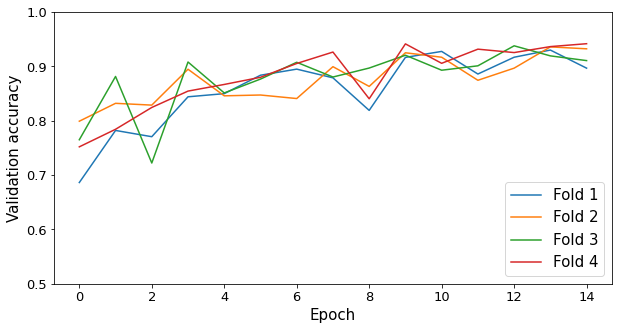

In [ ]:
plt.figure(figsize=(10,5))
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4']
for h in history_dict:
    plt.plot(h["val_binary_accuracy"], label=labels[history_dict.index(h)])
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Validation accuracy', fontsize=15)
    plt.ylim(0.5, 1)

plt.legend(loc='lower right', fontsize=15)

## Evaluation of the best model
* Find which fold contained the model with the highest validation accuracy, load this model and evaluate it on the test set and the complete training set.

In [ ]:
best_fold = np.argmax(valid_acc)
print(f'Fold {best_fold + 1} achieved the best validation accuracy of {(valid_acc[best_fold]):4f}')

Fold 4 achieved the best validation accuracy of 0.941675


In [ ]:
best_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + '-' + model_description['notes'] + '-' + str(best_fold + 1) + '.h5')

best_cnn = tf.keras.models.load_model(best_save)
train_gen, _, test_gen = get_generators(datagen, TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, CHANNEL_CNT, True, RAND_SEED)

# test set evaluation
score = best_cnn.evaluate(x=test_gen, verbose=1)

Found 15952 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
13/13 [==============================] - 63s 3s/step - loss: 0.3011 - binary_accuracy: 0.8975


In [ ]:
# training set evaluation
score = best_cnn.evaluate(x=train_gen, verbose=1)

499/499 [==============================] - 450s 901ms/step - loss: 0.1331 - binary_accuracy: 0.9521


In [ ]:
# calculation of other metrics based on the test set performance
test_gen.reset()
y_pred_prob = best_cnn.predict_generator(test_gen)
y_pred = y_pred_prob.copy()
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_true = np.asarray(test_gen.classes[test_gen.index_array])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       200
           1       0.93      0.85      0.89       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [ ]:
# Specificity (TPR)
tp/(tp+fn)

0.855

In [ ]:
# Sensitivity (TNR)
tn/(tn+fp)

0.94

In [ ]:
# Positive Predictive Value (PPV)
tp/(tp+fp)

0.9344262295081968

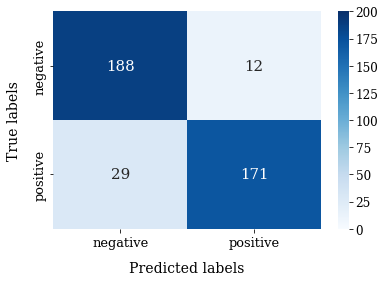

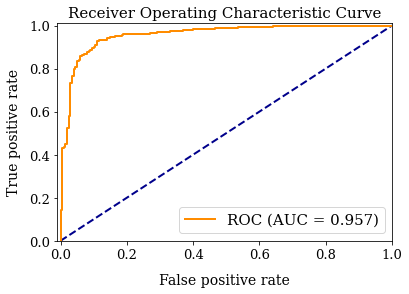

In [ ]:
plot_eval(y_true, y_pred_prob, y_pred)